In [1]:
import torch
import xarray as xr
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR

In [2]:
dataset_path = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr'
ds = xr.open_zarr(dataset_path, consolidated=True)
print(ds)

<xarray.Dataset> Size: 2TB
Dimensions:                                           (time: 93544,
                                                       longitude: 240,
                                                       latitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 968B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 2kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 11GB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float3

In [3]:
print("Dimensiones del dataset:", ds.dims)

Dimensiones del dataset: FrozenMappingWarningOnValuesAccess({'time': 93544, 'longitude': 240, 'latitude': 121, 'level': 13})


In [4]:
subset = ds.isel(latitude=slice(0, 100), longitude=slice(0, 100), time=slice(0, 10))  # Ajusta la región espacial
print(subset)

<xarray.Dataset> Size: 92MB
Dimensions:                                           (time: 10,
                                                       longitude: 100,
                                                       latitude: 100, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 800B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 800B ...
  * time                                              (time) datetime64[ns] 80B ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 400kB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 400kB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 400kB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float3

In [5]:
for var in subset.data_vars:
    print(f"{var}: {subset[var].shape}")

10m_u_component_of_wind: (10, 100, 100)
10m_v_component_of_wind: (10, 100, 100)
10m_wind_speed: (10, 100, 100)
2m_dewpoint_temperature: (10, 100, 100)
2m_temperature: (10, 100, 100)
above_ground: (10, 13, 100, 100)
ageostrophic_wind_speed: (10, 13, 100, 100)
angle_of_sub_gridscale_orography: (100, 100)
anisotropy_of_sub_gridscale_orography: (100, 100)
boundary_layer_height: (10, 100, 100)
divergence: (10, 13, 100, 100)
eddy_kinetic_energy: (10, 100, 100)
geopotential: (10, 13, 100, 100)
geopotential_at_surface: (100, 100)
geostrophic_wind_speed: (10, 13, 100, 100)
high_vegetation_cover: (100, 100)
integrated_vapor_transport: (10, 100, 100)
lake_cover: (100, 100)
land_sea_mask: (100, 100)
lapse_rate: (10, 13, 100, 100)
leaf_area_index_high_vegetation: (10, 100, 100)
leaf_area_index_low_vegetation: (10, 100, 100)
low_vegetation_cover: (100, 100)
mean_sea_level_pressure: (10, 100, 100)
mean_surface_latent_heat_flux: (10, 100, 100)
mean_surface_net_long_wave_radiation_flux: (10, 100, 100)


In [6]:
variables = ['u_component_of_wind', 'v_component_of_wind', 
             'temperature', 'specific_humidity', 'mean_sea_level_pressure']

subset_selected = subset[variables]
print(subset_selected)

<xarray.Dataset> Size: 21MB
Dimensions:                  (time: 10, level: 13, longitude: 100, latitude: 100)
Coordinates:
  * latitude                 (latitude) float64 800B -90.0 -88.5 ... 57.0 58.5
  * level                    (level) int64 104B 50 100 150 200 ... 850 925 1000
  * longitude                (longitude) float64 800B 0.0 1.5 ... 147.0 148.5
  * time                     (time) datetime64[ns] 80B 1959-01-01 ... 1959-01...
Data variables:
    u_component_of_wind      (time, level, longitude, latitude) float32 5MB ...
    v_component_of_wind      (time, level, longitude, latitude) float32 5MB ...
    temperature              (time, level, longitude, latitude) float32 5MB ...
    specific_humidity        (time, level, longitude, latitude) float32 5MB ...
    mean_sea_level_pressure  (time, longitude, latitude) float32 400kB ...


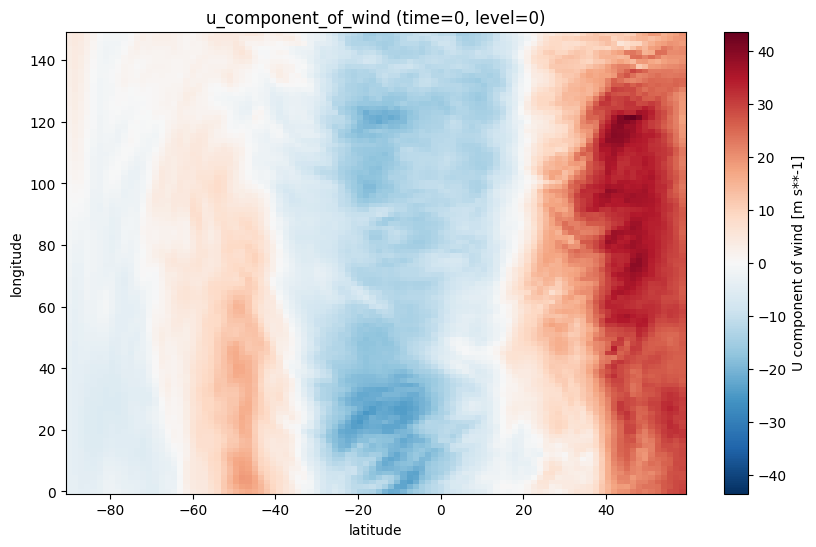

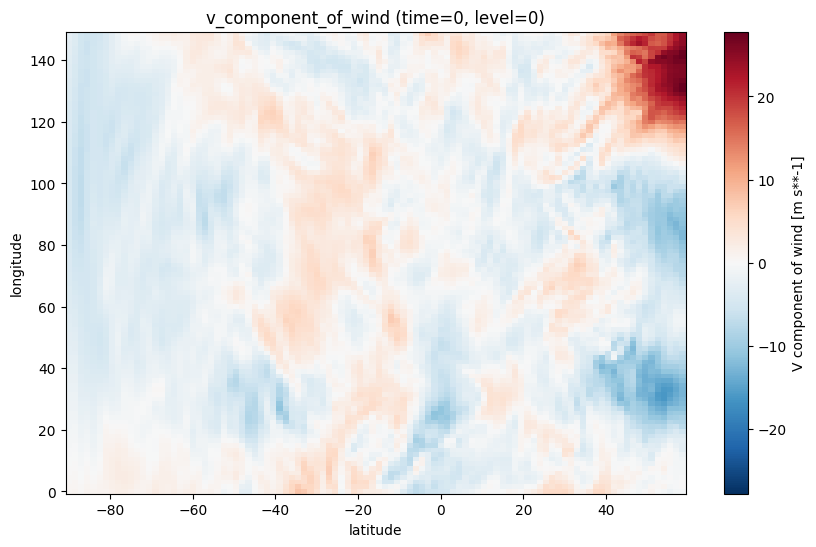

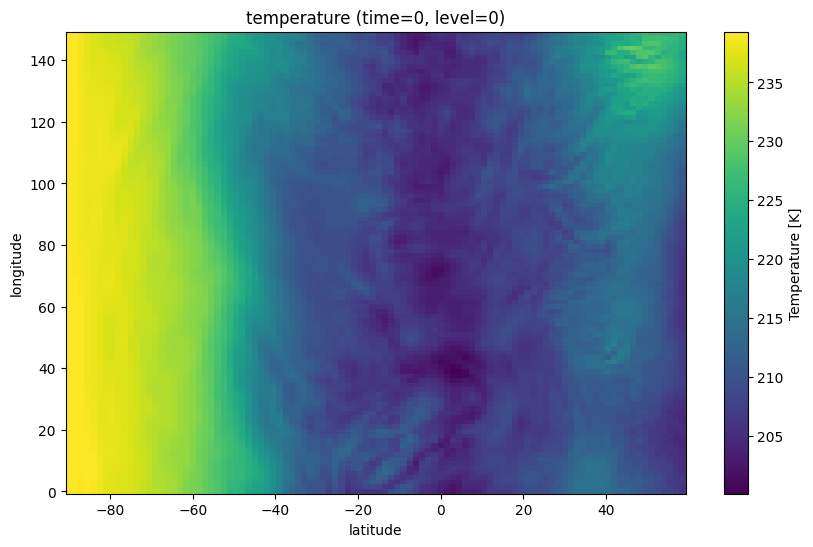

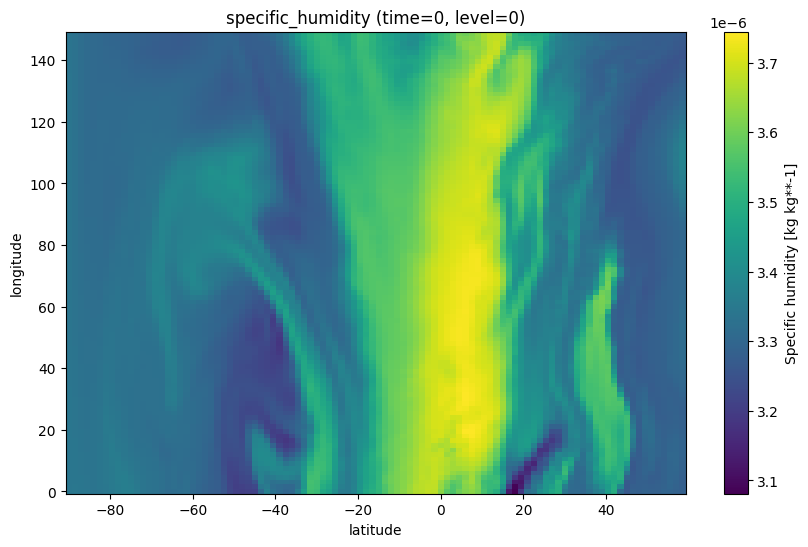

In [7]:
time_idx = 0  # Índice de tiempo
level_idx = 0  # Índice de nivel (si aplica)

for var in ['u_component_of_wind', 'v_component_of_wind', 
             'temperature', 'specific_humidity']:
    data = subset_selected[var].isel(time=time_idx, level=level_idx)
    plt.figure(figsize=(10, 6))
    data.plot()
    plt.title(f"{var} (time={time_idx}, level={level_idx})")
    plt.show()

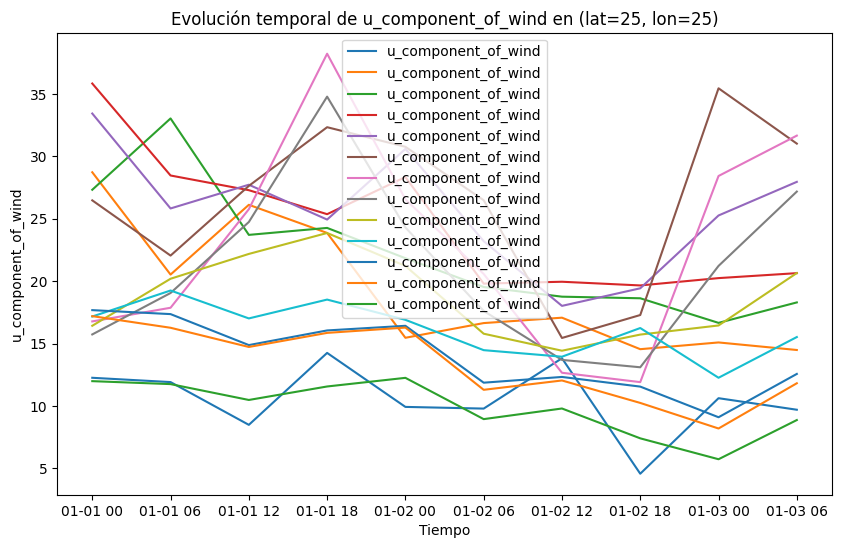

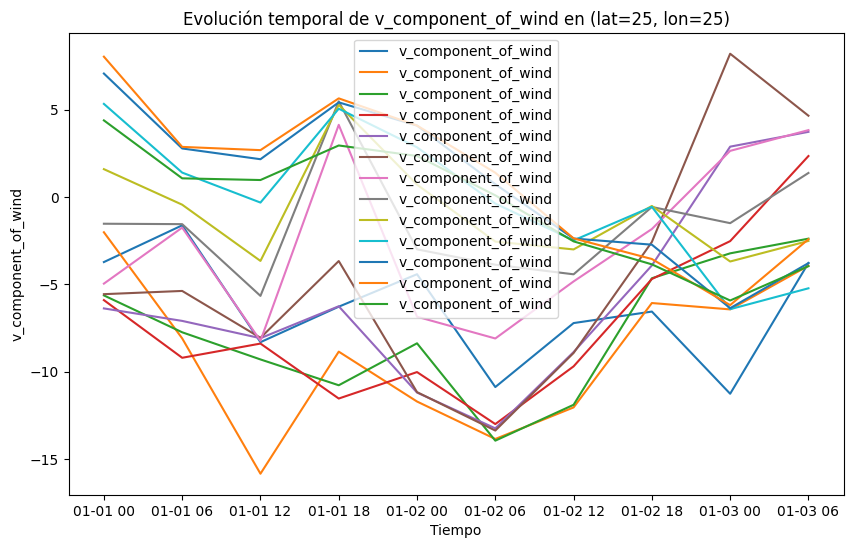

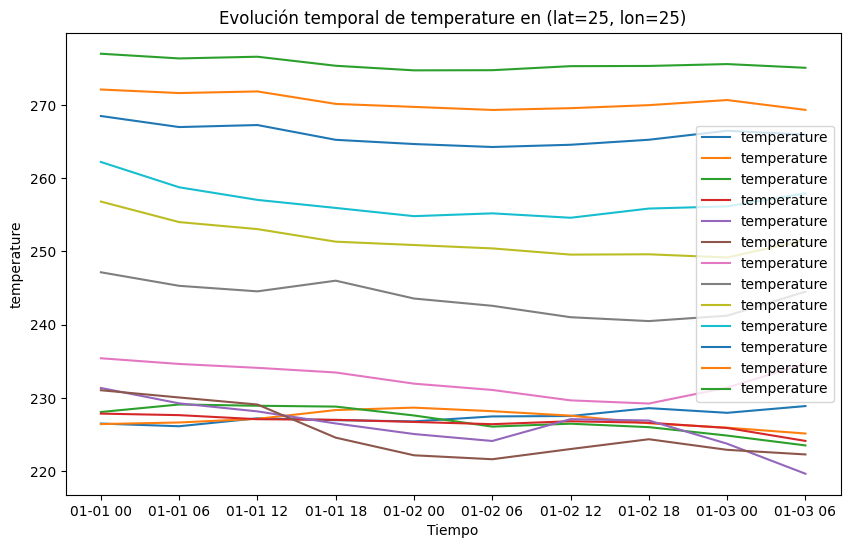

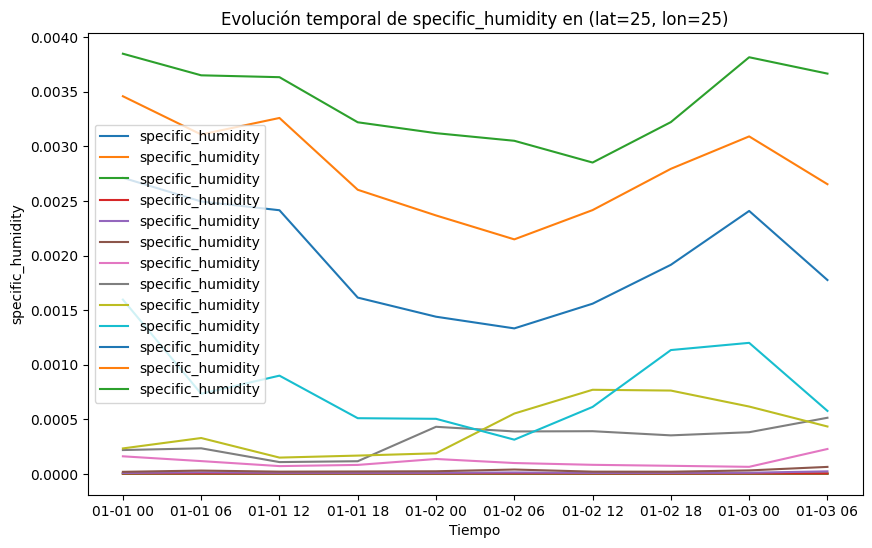

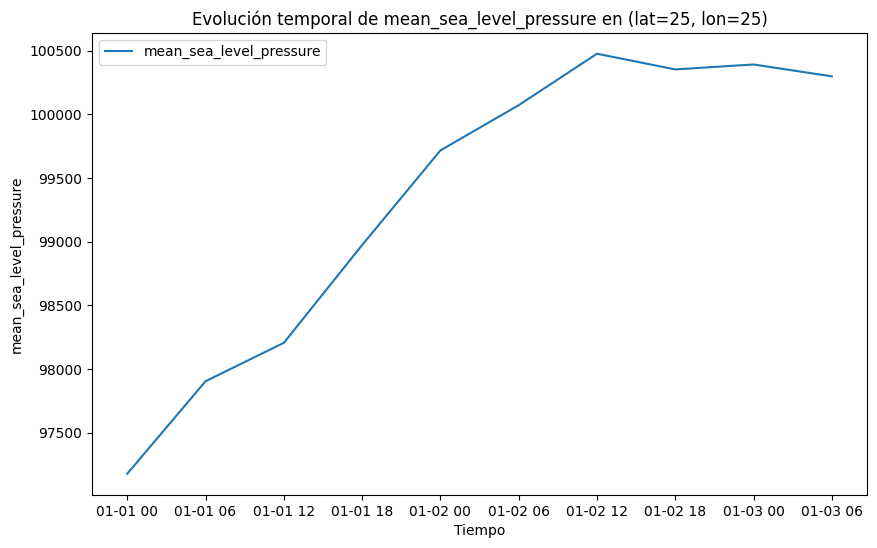

In [8]:
latitude_idx = 25  # Índice de latitud
longitude_idx = 25  # Índice de longitud

for var in variables:
    time_series = subset_selected[var].isel(latitude=latitude_idx, longitude=longitude_idx).values
    plt.figure(figsize=(10, 6))
    plt.plot(subset_selected['time'].values, time_series, label=var)
    plt.title(f"Evolución temporal de {var} en (lat={latitude_idx}, lon={longitude_idx})")
    plt.xlabel("Tiempo")
    plt.ylabel(var)
    plt.legend()
    plt.show()

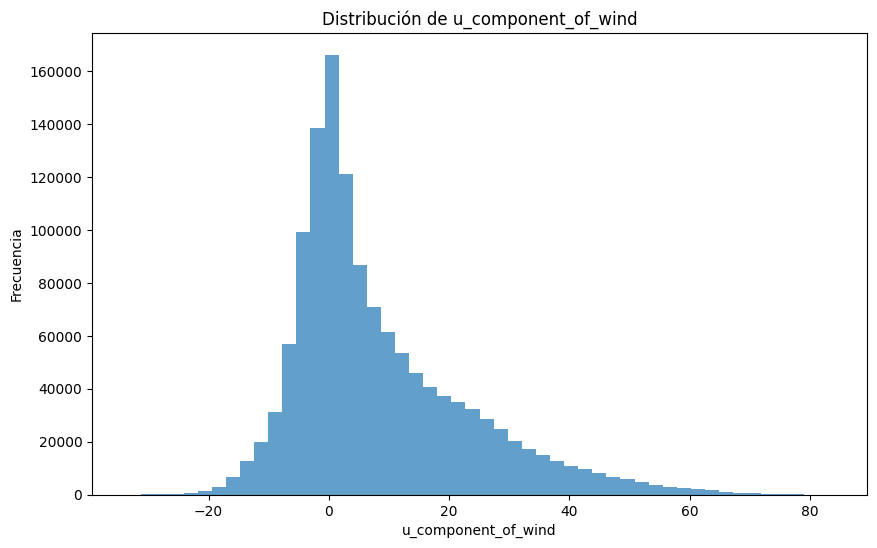

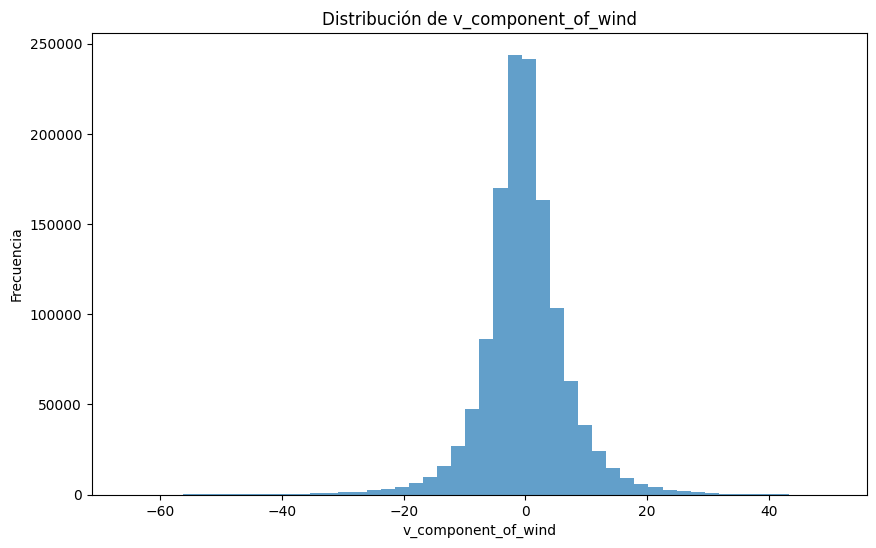

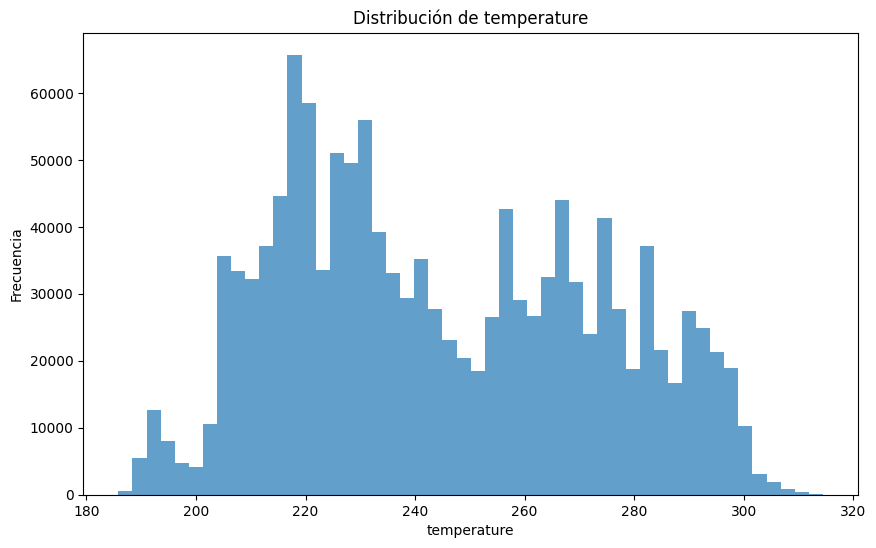

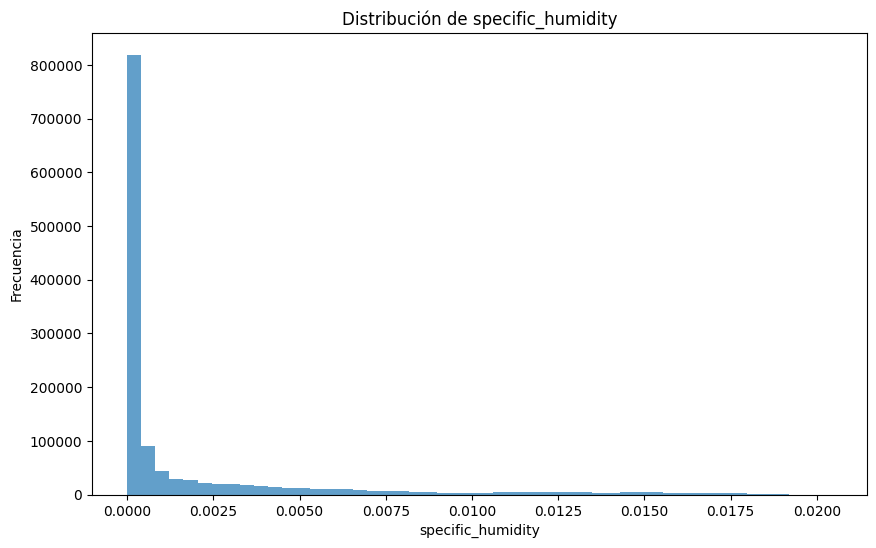

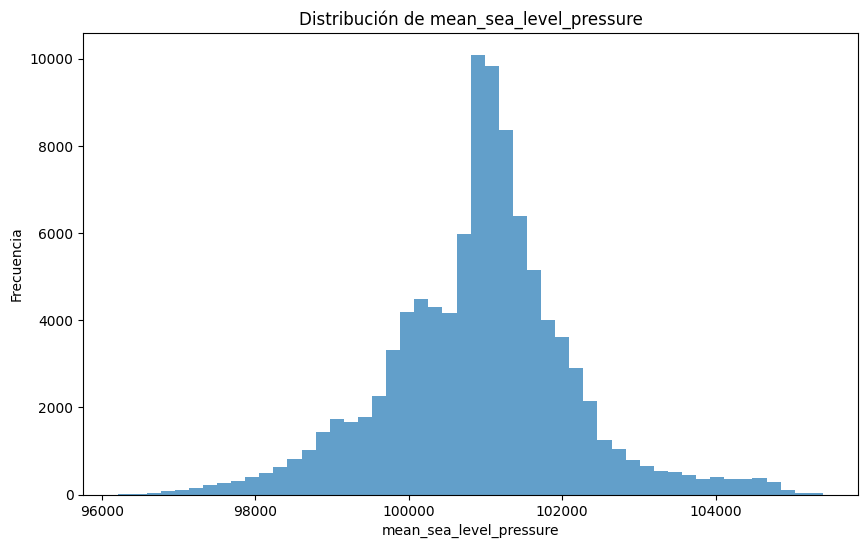

In [9]:
for var in variables:
    data = subset_selected[var].values.flatten()  # Aplanar los datos para el histograma
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, alpha=0.7)
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.show()

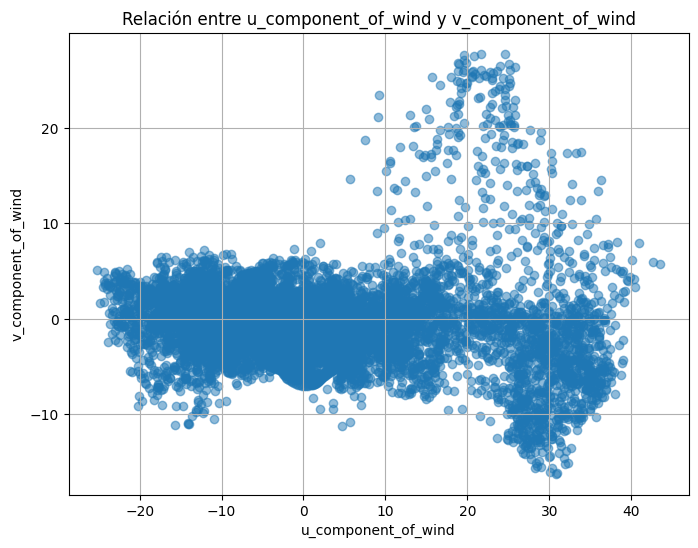

In [10]:
time_idx = 0
level_idx = 0

x_var = 'u_component_of_wind'
y_var = 'v_component_of_wind'

x_data = subset_selected[x_var].isel(time=time_idx, level=level_idx).values.flatten()
y_data = subset_selected[y_var].isel(time=time_idx, level=level_idx).values.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.title(f"Relación entre {x_var} y {y_var}")
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.grid()
plt.show()

In [11]:
print(f"Subset dimensions: {subset.dims}")
print(f"Timestamps in subset: {subset.sizes['time']}")
print(f"Latitude size: {subset.sizes['latitude']}, Longitude size: {subset.sizes['longitude']}")


Subset dimensions: FrozenMappingWarningOnValuesAccess({'time': 10, 'longitude': 100, 'latitude': 100, 'level': 13})
Timestamps in subset: 10
Latitude size: 100, Longitude size: 100


In [12]:
height, width = subset_selected.sizes['latitude'], subset_selected.sizes['longitude']
print(f"Height: {height}, Width: {width}")


Height: 100, Width: 100


In [13]:
levels = subset_selected.sizes['level']
print(f"Levels: {levels}")


Levels: 13


In [14]:
times = subset_selected.sizes['time']
print(f"Timestamps: {times}")


Timestamps: 10


In [15]:
train_idx = 7  # 7 timestamps para entrenamiento (70%)
val_idx = 9    # 2 timestamps para validación (20%)
test_idx = 10  # 1 timestamp para prueba (10%)

In [16]:
train_data = subset_selected.isel(time=slice(0, train_idx))
val_data = subset_selected.isel(time=slice(train_idx, val_idx))
test_data = subset_selected.isel(time=slice(val_idx, test_idx))

In [17]:
print(f"Train samples: {train_data.sizes['time']}")
print(f"Validation samples: {val_data.sizes['time']}")
print(f"Test samples: {test_data.sizes['time']}")

Train samples: 7
Validation samples: 2
Test samples: 1


In [18]:
means = train_data.mean(dim=('time', 'latitude', 'longitude')).compute()
stds = train_data.std(dim=('time', 'latitude', 'longitude')).compute()

In [19]:
def normalize_data(data, means, stds):
    normalized_data = (data - means) / stds
    return normalized_data

In [20]:
train_data_norm = normalize_data(train_data, means, stds)
val_data_norm = normalize_data(val_data, means, stds)
test_data_norm = normalize_data(test_data, means, stds)

In [21]:
def convert_to_tensors(data):
    """
    Convierte datos de xarray a tensores PyTorch.
    """
    data_tensor = torch.tensor(data.to_array().values, dtype=torch.float32)
    data_tensor = data_tensor.permute(1, 0, 2, 3)  # (time, variables, lat, lon) -> (time, channels, height, width)
    return data_tensor

# Seleccionar un nivel específico
train_data_norm = train_data_norm.isel(level=0)
val_data_norm = val_data_norm.isel(level=0)
test_data_norm = test_data_norm.isel(level=0)

# Luego convertir a tensores
train_tensor = convert_to_tensors(train_data_norm)
val_tensor = convert_to_tensors(val_data_norm)
test_tensor = convert_to_tensors(test_data_norm)

# Confirmar formas
print(f"Train tensor shape: {train_tensor.shape}")
print(f"Validation tensor shape: {val_tensor.shape}")
print(f"Test tensor shape: {test_tensor.shape}")

Train tensor shape: torch.Size([7, 5, 100, 100])
Validation tensor shape: torch.Size([2, 5, 100, 100])
Test tensor shape: torch.Size([1, 5, 100, 100])


In [33]:
from torch.utils.data import DataLoader, TensorDataset

# Crear datasets
train_dataset = TensorDataset(train_tensor[:-1], train_tensor[1:])  # Usar datos consecutivos
val_dataset = TensorDataset(val_tensor[:-1], val_tensor[1:])
test_dataset = TensorDataset(test_tensor[:-1], test_tensor[1:])

# Crear DataLoaders
batch_size = 128  # Ajustar según la memoria disponible
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Confirmar tamaños
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 1
Number of batches in val_loader: 1
Number of batches in test_loader: 0


In [56]:
class PINNWithCNN(nn.Module):
    def __init__(self):
        super(PINNWithCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2) 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.conv3 = nn.Conv2d(128, 5, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = self.conv3(x)
        return x


In [35]:
print(f"Validation tensor shape: {val_tensor.shape}")


Validation tensor shape: torch.Size([2, 5, 100, 100])


In [36]:
if len(train_loader) == 0:
    raise ValueError("Train loader is empty. Check the dataset or batch size.")
if len(val_loader) == 0:
    raise ValueError("Validation loader is empty. Check the dataset or batch size.")


In [37]:
def compute_gradients(output, inputs):
    """
    Calcula gradientes parciales de la salida respecto a las dimensiones espaciales y temporales.
    """
    # Asumimos que inputs tiene las dimensiones (batch_size, channels, height, width)
    grad = torch.autograd.grad(
        outputs=output.sum(),  # Sumar para obtener gradiente escalar
        inputs=inputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    # Extraer gradientes para las dimensiones espaciales y temporales
    return grad[:, 2], grad[:, 3], grad[:, 4]  # Ajustar según tus inputs


In [38]:
def loss_pde(model, inputs, alpha=1.0):
    """
    Calcula la pérdida física basada en las ecuaciones.
    """
    inputs.requires_grad_(True)  # Habilitar gradientes para las entradas
    pred = model(inputs)

    # Separar predicciones
    u_pred = pred[:, 0, :, :]
    v_pred = pred[:, 1, :, :]
    p_pred = pred[:, 2, :, :]
    T_pred = pred[:, 3, :, :]
    q_pred = pred[:, 4, :, :]

    # Calcular gradientes para cada término
    u_x, u_y, u_t = compute_gradients(u_pred, inputs)
    v_x, v_y, v_t = compute_gradients(v_pred, inputs)
    T_x, T_y, T_t = compute_gradients(T_pred, inputs)
    q_x, q_y, q_t = compute_gradients(q_pred, inputs)
    p_x, p_y, _ = compute_gradients(p_pred, inputs)

    # Definir ecuaciones físicas
    momentum_u = u_t + u_pred * u_x + v_pred * u_y + p_x
    momentum_v = v_t + u_pred * v_x + v_pred * v_y + p_y
    continuity = u_x + v_y
    energy = T_t + u_pred * T_x + v_pred * T_y
    moisture = q_t + u_pred * q_x + v_pred * q_y

    # Calcular pérdida física
    loss_physics = (
        torch.mean(momentum_u ** 2) +
        torch.mean(momentum_v ** 2) +
        torch.mean(continuity ** 2) +
        torch.mean(energy ** 2) +
        torch.mean(moisture ** 2)
    )

    return alpha * loss_physics


In [39]:
def compute_accuracy(pred, target, tolerance=0.05):
    """
    Calcula el porcentaje de predicciones dentro de un rango de tolerancia.
    - pred: Tensores de predicciones.
    - target: Tensores de valores objetivo.
    - tolerance: Rango relativo permitido (por defecto 5%).
    """
    relative_error = torch.abs((pred - target) / (target + 1e-8))  # Evitar divisiones por 0
    accurate_predictions = torch.sum(relative_error <= tolerance).item()
    total_predictions = target.numel()  # Total de elementos
    return (accurate_predictions / total_predictions) * 100  # Porcentaje


In [58]:
def lr_lambda(epoch):
    warmup_epochs = 50  # Épocas de warm-up
    if epoch < warmup_epochs:
        return epoch / warmup_epochs  # Incremento lineal durante el warm-up
    else:
        return 0.5 * (1 + torch.cos((epoch - warmup_epochs) / (2000 - warmup_epochs) * torch.pi))

In [40]:
from torch.optim.lr_scheduler import LambdaLR

def train_model_with_physics(
    model, train_loader, val_loader, optimizer, loss_pde_fn, compute_accuracy_fn, device, epochs=200, alpha=0.2
):
    # Inicializar listas para métricas
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []  # Corregido
    train_loss_data_history, train_loss_physics_history = [], []
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

    # Entrenamiento
    for epoch in range(epochs):
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        train_loss_data, train_loss_physics = 0.0, 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Habilitar gradientes en las entradas
            inputs.requires_grad_(True)
            pred = model(inputs)

            # Calcular pérdidas
            loss_physics = loss_pde_fn(model, inputs)
            loss_data = torch.nn.functional.mse_loss(pred, targets)
            loss = loss_data + alpha * loss_physics

            # Backpropagación
            loss.backward()
            optimizer.step()

            # Acumular métricas
            train_loss += loss.item()
            train_loss_data += loss_data.item()
            train_loss_physics += loss_physics.item()
            train_accuracy += compute_accuracy_fn(pred, targets)

        # Promediar métricas de entrenamiento
        train_loss /= len(train_loader)
        train_loss_data /= len(train_loader)
        train_loss_physics /= len(train_loader)
        train_accuracy /= len(train_loader)
        scheduler.step()
        
        # Validación
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                pred = model(inputs)
                val_loss += torch.nn.functional.mse_loss(pred, targets).item()
                val_accuracy += compute_accuracy_fn(pred, targets)

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

        # Guardar métricas
        train_losses.append(train_loss)
        train_loss_data_history.append(train_loss_data)
        train_loss_physics_history.append(train_loss_physics)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Imprimir una sola línea por época
        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {train_loss:.6f}, Train Data Loss: {train_loss_data:.6f}, "
            f"Train Physics Loss: {train_loss_physics:.6f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%"
        )
    # Retornar métricas
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde,
    compute_accuracy_fn=compute_accuracy,
    device=device,
    epochs=2000,
    alpha=0.1
)

Epoch 1/2000, Train Loss: 1.289784, Train Data Loss: 1.217284, Train Physics Loss: 0.725006, Train Accuracy: 1.09%, Validation Loss: 1.000781, Validation Accuracy: 0.27%
Epoch 2/2000, Train Loss: 1.290900, Train Data Loss: 1.218547, Train Physics Loss: 0.723536, Train Accuracy: 1.10%, Validation Loss: 0.971596, Validation Accuracy: 0.26%
Epoch 3/2000, Train Loss: 1.169394, Train Data Loss: 1.097817, Train Physics Loss: 0.715766, Train Accuracy: 1.18%, Validation Loss: 0.902751, Validation Accuracy: 0.28%
Epoch 4/2000, Train Loss: 0.954039, Train Data Loss: 0.884406, Train Physics Loss: 0.696330, Train Accuracy: 1.41%, Validation Loss: 0.787201, Validation Accuracy: 0.31%
Epoch 5/2000, Train Loss: 0.708797, Train Data Loss: 0.640157, Train Physics Loss: 0.686399, Train Accuracy: 2.01%, Validation Loss: 0.629473, Validation Accuracy: 0.45%
Epoch 6/2000, Train Loss: 0.503545, Train Data Loss: 0.435696, Train Physics Loss: 0.678496, Train Accuracy: 3.43%, Validation Loss: 0.454093, Validat

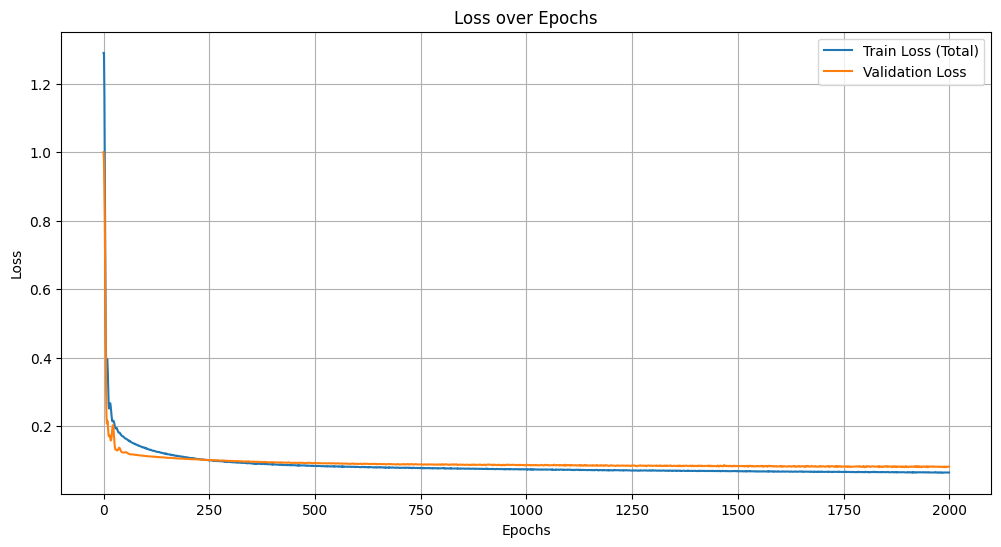

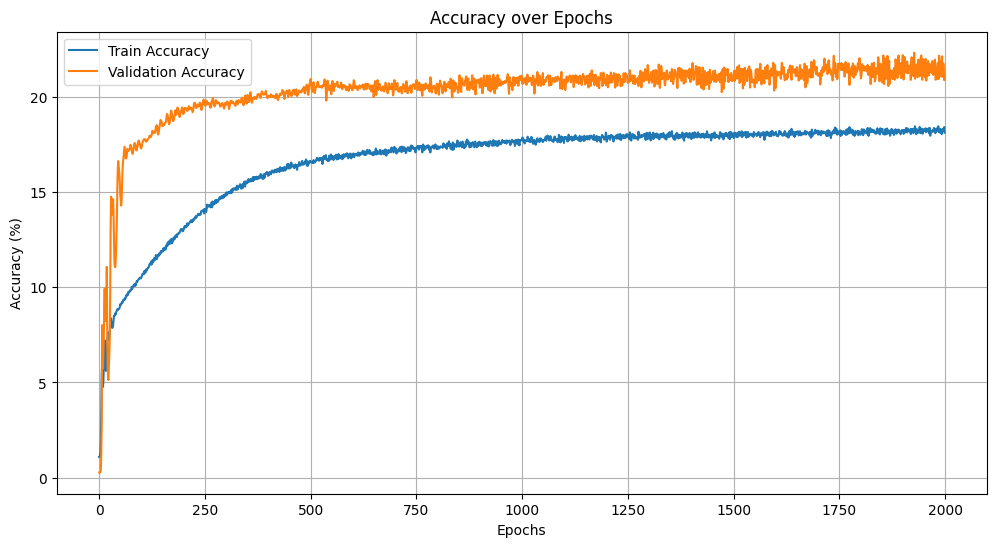

In [59]:
# Extraer métricas
train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accuracies = metrics["train_accuracies"]
val_accuracies = metrics["val_accuracies"]

# Graficar las pérdidas
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss (Total)")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

# Graficar el accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()
